In [5]:
from scipy.fft import fft, ifft, fftfreq, fftshift
import numpy as np
import matplotlib.pyplot as plt
import random as rn

# Monte-Carlo

In [7]:
def scattering(l_ph, g, thetha0, phi0, init):
    #прошедший путь до столкновения
    r1 = rn.random()
    while r1 == 0 or r1 == 1:
        r1 = rn.random() 
    length = -l_ph*np.log(1-r1)

    #угол отклонения по оси z в новой СК
    r_th = rn.random()
    while r_th == 0 or r_th == 1:
        r_th = rn.random()
    #Хенья-Гринштейн
    th = np.arccos((1 + g**2 - ((1 - g**2)/(1-g+2*g*r_th))**2)/ 2/g)

    #угол отклонения в плоскости xy в новой СК
    phi = rn.uniform(0.0,1.0)*2*np.pi

    #углы отклонения в старой СК
    thetha0 = th + thetha0
    phi0 = phi + phi0

    #координаты столкновения в старой СК
    x1 = init[0] + length*np.sin(thetha0)*np.cos(phi0)
    y1 = init[1] + length*np.sin(thetha0)*np.sin(phi0)
    z1 = init[2] + length*np.cos(thetha0)

    return x1, y1, z1, thetha0, phi0, length

In [8]:
def layers(x1, y1, z1, length, L, n1, n2, th0, phi0, init, x, z, y):
    
    rt = rn.random()
    #длина пробега до линии разделения слоев
    l_before = length - (z1 - L)/np.cos(th0)
    
    #координаты в плоскости xy точки на линии разделения
    x_refl = init[0] + l_before*np.sin(th0)*np.cos(phi0)
    y_refl = init[1] + l_before*np.sin(th0)*np.sin(phi0)
    #запись точки в массив столкновений
    x.append(x_refl), y.append(y_refl), z.append(L)
    
    #условие на полное внутреннее отражение
    if abs(np.sin(th0)) <= n2/n1:
        #учет направления распространения
        sn = np.sign(np.cos(th0))
        if sn < 0:
            th_refr = np.pi - np.arcsin(n1*np.sin(th0)/n2)
        else:
            th_refr = np.arcsin(n1*np.sin(th0)/n2)

        #коэффициенты отражения
        r_s = (n1*np.cos(th0) - n2*np.cos(th_refr))/(n1*np.cos(th0) + n2*np.cos(th_refr))
        r_p = (n2*np.cos(th0) - n1*np.cos(th_refr))/(n2*np.cos(th0) + n1*np.cos(th_refr))
        refl = (abs(r_s)**2+abs(r_p)**2)/2
        
        if rt < refl:
            #отражение
            #угол отражения
            th0 = np.pi - th0
            #координаты до нового столкновения
            x1 = init[0] + length*np.sin(th0)*np.cos(phi0)
            y1 = init[1] + length*np.sin(th0)*np.sin(phi0)
            z1 = 2*L - z1
        else:
            #пропускание
            #угол преломления
            th0 = th_refr
            #координаты до нового столкновения
            x1 = x_refl + (length - l_before)*np.sin(th0)*np.cos(phi0)
            y1 = y_refl + (length - l_before)*np.sin(th0)*np.sin(phi0)
            z1 = L + (length - l_before)*np.cos(th0)


    else:
        #полное внутреннее отражение
        x1 = x_refl + (length-l_before)*np.cos(phi0)
        y1 = y_refl + (length - l_before)*np.sin(phi0)
        #учет направления распространения
        if x1 > x_refl:
            th0 = np.pi/2
        else:
            th0 = - np.pi/2
        z1 = L

    return x1, y1, z1, th0, phi0

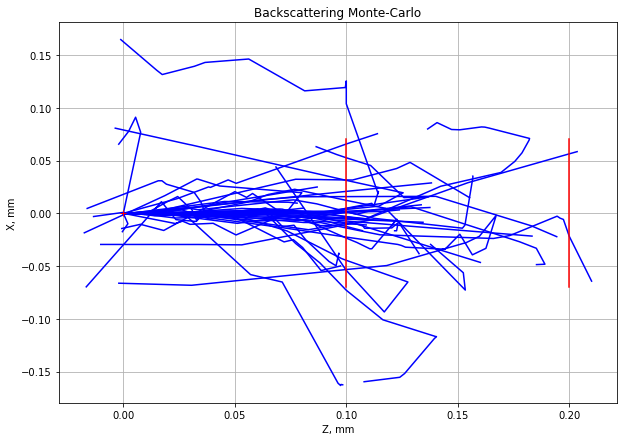

Обратно рассеяные 14.57 %


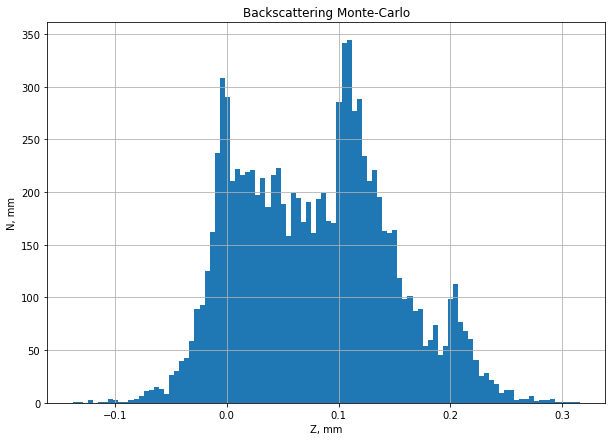

In [9]:
%matplotlib inline

#количество выводимых траекторий
graphs = 0
N_gr = 50

#показатеди преломдения сред
n1 = 1.4
n2 = 1.45
n3 = 1.47

#коэф абсорбции и рассеяния сред
mu_a = 4
mu_s = 42.5
mu_a1 = 7
mu_s1 = 30

#факторы анизотропии
g = 0.97
g1 = 0.85

#Ширины слоев
L = 0.1
L1 = 0.2

#Длина свободного пробега
l0 = 1/(mu_a + mu_s)
l01 = 1/(mu_a1 + mu_s1)

z_absorb = []
back = 0

#количество фотонов
N = 10000

#визуализация траекторий
fig, ax = plt.subplots(figsize =(10, 7))

for _ in range(N):
    #вероятность поглощения/рассеяния
    a = 0
    #начальная точка
    init = [0,0,0]
    #массивы коордитнат столкновений
    x, y, z = [0], [0], [0]
    #начальный угол распространения
    th0, phi0 = 0, 0
    
    #распространение в первом слое
    while a <= mu_s/(mu_a+mu_s) and  init[2] <= L:

        #пробег
        x1, y1, z1, th0, phi0, length = scattering(l0, g, th0, phi0, init)
        #проверка границы слоя
        if z1 > L:
            x1, y1, z1, th0, phi0 = layers(x1, y1, z1, length, L, n1, n2, th0, phi0, init, x, z, y)
        
        x.append(x1), y.append(y1), z.append(z1)
        init = [x1,y1,z1]
        a = rn.random()
        
        #вылет из иследуемой области
        if z1 < 0:
            back = back + 1
            break
        
        #распространение во втором слое
        while a <= mu_s1/(mu_a1+mu_s1) and L < init[2] <= L1:

            #пробег
            x1, y1, z1, th0, phi0, length = scattering(l01, g1, th0, phi0, init)
            #проверка границы слоя
            if z1 > L1:
                x1, y1, z1, th0, phi0 = layers(x1, y1, z1, length, L1, n2, n3, th0, phi0, init, x, z, y)
            elif z1 < L:
                x1, y1, z1, th0, phi0 = layers(x1, y1, z1, length, L, n2, n1, th0, phi0, init, x, z, y)
                
            x.append(x1), y.append(y1), z.append(z1)
            init = [x1,y1,z1]
            a = rn.random()
        
    #запись данных и вывод
    z_absorb.append(z[-1])
    if graphs < N_gr:
        plt.plot(z, x,'b')
        graphs = graphs + 1

#линии разделения слоев
f11 = [L, L]
f12 = [-0.07, 0.07]
f21 = [L1, L1]
f22 = f12

plt.plot(f11, f12, 'r')
plt.plot(f21, f22, 'r')
plt.plot(0,0, 'r+')
plt.grid()
plt.title('Backscattering Monte-Carlo')
plt.xlabel('Z, mm')
plt.ylabel('X, mm')
plt.show()

print('Обратно рассеяные', back/N*100, '%')

# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(z_absorb, bins = 100)
plt.grid()
plt.title('Backscattering Monte-Carlo')
plt.xlabel('Z, mm')
plt.ylabel('N, mm')
# Show plot
plt.show()

# Черновуха

In [ ]:
import random as rn

#начальные данные
n1 = 1.4
n2 = 1.44
mu_a = 4
mu_s = 42.5
L = 0.1
l0 = 1/(mu_a + mu_s)
g = 0.97

#число фотонов, вылетивших из области
back = 0

#число фотонов, прошедших через слой
transmitted = 0

#число фотонов
N = 100
for _ in range(N):
    
    init = [0,0,0]
    a = 0
    x = [0]
    z = [0]
    th0, phi0 = 0, 0
    
    #условие рассеения/поглощения
    while a <= mu_s/(mu_a+mu_s):

        #прошедший путь до столкновения
        r1 = rn.random()
        while r1 == 0 or r1 == 1:
            r1 = rn.random() 
        length = -l0*np.log(1-r1)

        #угол отклонения по оси z в новой СК
        r_th = rn.random()
        while r_th == 0 or r_th == 1:
            r_th = rn.random()
        th = np.arccos((1 + g**2 - ((1 - g**2)/(1-g+2*g*r_th))**2)/ 2/g)

        #угол отклонения в плоскости xy в новой СК
        phi = rn.uniform(0.0,1.0)*2*np.pi

        #углы отклонения в старой СК
        th0 = th + th0
        phi0 = phi + phi0

        #координаты столкновения в старой СК
        x1 = init[0] + length*np.sin(th0)*np.cos(phi0)
        y1 = init[1] + length*np.sin(th0)*np.sin(phi0)
        z1 = init[2] + length*np.cos(th0)

        #учет следущего рассеения/поглощения
        a = rn.random()

###############################################################
        #условие на отражение от линии разделения слоев
        if z1 > L:

            rt = rn.random()

            #угол преломления
            th_refr = np.arcsin(n1*np.sin(th0)/n2)

            #коэффициенты отражения
            r_s = (n1*np.cos(th0) - n2*np.cos(th_refr))/(n1*np.cos(th0) + n2*np.cos(th_refr))
            r_p = (n2*np.cos(th0) - n1*np.cos(th_refr))/(n2*np.cos(th0) + n1*np.cos(th_refr))
            refl = (abs(r_s)**2+abs(r_p)**2)/2

            #длина пробега до линии разделения слоев
            l_before = length - (z1 - L)/np.cos(th0)

            #координаты в плоскости xy точки на линии разделения
            x_refl = init[0] + l_before*np.sin(th0)*np.cos(phi0)
            y_refl = init[1] + l_before*np.sin(th0)*np.sin(phi0)
            x.append(x_refl), z.append(L)

            if rt < refl:
                #отражение
                z1 = 2*L - z1
                th0 = np.pi - th0
                x1 = init[0] + length*np.sin(th0)*np.cos(phi0)
                y1 = init[1] + length*np.sin(th0)*np.sin(phi0)
            else:
                #пропускание
                th0 = th_refr
                x1 = x_refl + (length - l_before)*np.sin(th0)*np.cos(phi0)
                y1 = y_refl + (length - l_before)*np.sin(th0)*np.sin(phi0)
                z1 = L + (length - l_before)*np.cos(th0)
#                transmitted = transmitted + 1
                a = 1

#########################################################################                
            
        x.append(x1), z.append(z1)
        init = [x1,y1,z1]
        if z1 < 0:
            back = back + 1
            break
    
    plt.plot(z, x)
    
plt.grid()
plt.title('Backscattering_Monte-Carlo')
plt.xlabel('Z, mm')
plt.ylabel('X, mm')
plt.show()
print('Обратно рассеяные', back/N*100, '%')
#print(transmitted/N*100, '%')